In [1]:
%matplotlib inline
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import activations
from tensorflow.keras import initializers
from keras.models import Model
from keras.utils import Sequence
from keras.utils import load_img
from keras.optimizers import RMSprop
from keras.optimizers import Adam

2023-01-27 16:55:11.402640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 16:55:13.184553: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /appl/cudnn/v8.3.2.44-prod-cuda-11.5/lib:/appl/cuda/11.6.0/lib64:/appl/python/3.10.7/lib:/appl/gcc/11.3.0-binutils-2.38/lib64:/appl/gcc/11.3.0-binutils-2.38/lib:/lsf/10.1/linux3.10-glibc2.17-x86_64/lib
2023-01-27 16:55:13.185116: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so

In [2]:
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import activations
from tensorflow.keras import initializers


In [3]:
!nvidia-smi

Fri Jan 27 16:55:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:37:00.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      4MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:AF:00.0 Off |                    0 |
| N/A   

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
df = pd.read_csv('black_background_500x500.csv')
train_df = df[df['ImagePath'].str.contains("train")]
test_df = df[df['ImagePath'].str.contains("test")]
valid_df = df[df['ImagePath'].str.contains("valid")]

input_size = 500

In [6]:
#########################################################
################## data generator #######################
#########################################################
class datagenerator(tf.keras.utils.Sequence):
    def __init__(self, 
            batch_size, 
            img_size,
            data_paths_df,
            input_channels,
            output_channels):
         
        self.batch_size = batch_size
        self.img_size = img_size
        self.data_paths_df = data_paths_df
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.data_paths = data_paths_df.values[:,1]
        self.params = data_paths_df.values[:,3:6]
        assert len(self.data_paths) == len(self.params)
        
        self.n = len(self.data_paths)

    def on_epoch_end(self):
        'updates indexes after each epoch'
        self.data_paths_df = self.data_paths_df.sample(frac = 1)
        self.data_paths = self.data_paths_df.values[:,1]
        self.params = self.data_paths_df.values[:,3:6]
    
    def __getitem__(self, index):
        batch_data_paths = self.data_paths[index : index + self.batch_size]
        batch_params_paths = self.params[index : index + self.batch_size]

        return self.__dataloader(self.img_size,
                batch_data_paths, batch_params_paths,
                self.input_channels, self.output_channels)
    
    def __len__(self):
        return self.n // self.batch_size

    #################### data loader ########################
    def __dataloader(self, 
            img_size,
            data_paths,
            batch_params_paths,
            input_channels,
            output_channels):
        x = np.zeros((len(data_paths), img_size[0], img_size[1], input_channels))
        y = batch_params_paths        
        
        for i in range(len(data_paths)):
            data = load_img(path = data_paths[i], color_mode = "grayscale")
            data = tf.keras.utils.img_to_array(data, data_format="channels_last", dtype="float32")
            data /= 255
#             data.shape = (1,) + data.shape
            x[i] = np.asarray(data)
        return x.astype("float32"), np.array(y).astype("float32")

In [7]:
def conv_block(x, filters, kernel_size, regul):
    if regul:
        biasregul = regularizers.l2(regul)
        kernelregul = regularizers.l2(regul)
    else:
        biasregul = kernelregul = None
    x = layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            kernel_initializer='RandomNormal',
            padding="same",
            bias_initializer=initializers.Constant(0.1),
            kernel_regularizer=kernelregul,
            bias_regularizer=biasregul
            )(x)
    x = layers.PReLU(
            shared_axes=[1,2],
            alpha_initializer=tf.initializers.Constant(0.01),
            )(x)
    x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)
#     x = layers.Dropout(rate=0.5)(x)
    
    return x

def mega_conv_block(x, filters, kernel_size, regul):
    # Skip
    previous_block_activation = x
    # Residual block
    x = conv_block(x, channels, 5, regul)
    x = conv_block(x, channels, 3, regul)
    x = conv_block(x, channels, 3, regul)
    x = layers.concatenate([x, previous_block_activation])
    # Exit 
    x = conv_block(x, channels, 3, regul)
    # Max pool
    x = layers.MaxPooling2D(pool_size=4, padding='same')(x)
    return x

In [8]:
regul = 0.01
channels = 4
inputs = keras.Input(shape=(input_size, input_size, 1))
x = inputs
# Entry
x = conv_block(x, channels, 11, regul)
x = conv_block(x, channels, 11, regul)
x = layers.MaxPooling2D(pool_size=4, padding='same')(x)
x = conv_block(x, channels, 5, regul)
x = conv_block(x, channels, 5, regul)
x = layers.MaxPooling2D(pool_size=4, padding='same')(x)
x = conv_block(x, channels, 3, regul)
x = conv_block(x, channels, 3, regul)
x = layers.MaxPooling2D(pool_size=4, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.Dropout(rate=0.5)(x)
outputs = layers.Dense(3)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 500, 500, 4)       488       
                                                                 
 p_re_lu (PReLU)             (None, 500, 500, 4)       4         
                                                                 
 batch_normalization (BatchN  (None, 500, 500, 4)      16        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 500, 500, 4)       1940      
                                                                 
 p_re_lu_1 (PReLU)           (None, 500, 500, 4)       4         
                                                             

2023-01-27 16:55:17.188417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 16:55:17.915612: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14610 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, compute capability: 7.0


 conv2d_3 (Conv2D)           (None, 125, 125, 4)       404       
                                                                 
 p_re_lu_3 (PReLU)           (None, 125, 125, 4)       4         
                                                                 
 batch_normalization_3 (Batc  (None, 125, 125, 4)      16        
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 4)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 4)         148       
                                                                 
 p_re_lu_4 (PReLU)           (None, 32, 32, 4)         4         
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 4)        16        
 hNormaliz

In [9]:
import keras.backend as K
  
def abs_loss_function(y_true, y_pred):   
    abs_diff = K.abs(y_true - y_pred)
    ones = tf.ones_like(y_true)
    abs_diff_reversed = K.abs(ones - abs_diff )   
    minimum_from_two = tf.math.minimum(abs_diff, abs_diff_reversed) 
    return tf.math.reduce_mean(minimum_from_two, axis=-1)

In [10]:
from keras.callbacks import *

In [11]:
test_g = datagenerator(32, (input_size,input_size), test_df, 1, 3)
evaluation_list = []
accuracy_list = []
class LossHistory(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0:
            print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
            m_e = self.model.evaluate(test_g, batch_size=32)
            for i in range(10):
                evaluation_list.append(m_e[0])
                accuracy_list.append(m_e[2])
            print("Loss on test data: ", m_e[0])
            for nr in range(3):
                t = test_df.values[nr][1]
                data = load_img(path = t, grayscale = True)
                data = tf.keras.utils.img_to_array(data, data_format="channels_last", dtype="float32")
                data /= 255
                data.shape = (1,) + data.shape
                X = np.asarray(data)
                print("----------{}----------".format(nr))
                euler = t.split("_")
                print("phi1", float(euler[3]))
                print("PHI",   float(euler[4]))
                print("phi2",  float(euler[5][:-4]))
                yhat = model.predict(data)
                print("predicted values", yhat*90)
            print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++")


In [12]:
model.compile(optimizer = RMSprop(learning_rate=0.001),
              loss = abs_loss_function, 
              metrics = [abs_loss_function, "accuracy"],
              run_eagerly=True)  # Add run_eagerly=True to enable the numpy debugging

tg = datagenerator(32, (input_size,input_size), train_df, 1, 3)
vg = datagenerator(32, (input_size,input_size), valid_df, 1, 3)
history = model.fit(x=tg,
                    batch_size=32,
                    epochs=100,
                    validation_data=vg,
                    callbacks=[LossHistory()])

Epoch 1/100


2023-01-27 16:55:19.874486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8302


31/31 [==============================] - 9s 297ms/step - loss: 0.3050 - abs_loss_function: 0.2403 - accuracy: 0.4012
Loss on test data:  0.30500030517578125
----------0----------
phi1 54.7
PHI 36.1
phi2 23.5
1/1 [==============================] - 0s 95ms/step


/zhome/ab/7/153983/project/venv/lib/python3.10/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


predicted values [[-22.279182  26.290436  56.666805]]
----------1----------
phi1 76.0
PHI 83.7
phi2 2.9
1/1 [==============================] - 0s 31ms/step
predicted values [[ 0.82006454 34.509064   56.237083  ]]
----------2----------
phi1 17.8
PHI 63.8
phi2 50.8
1/1 [==============================] - 0s 30ms/step
predicted values [[-20.584854  28.2278    57.504776]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
273/273 [==============================] - 93s 326ms/step - loss: 0.5535 - abs_loss_function: 0.4717 - accuracy: 0.3338 - val_loss: 0.2974 - val_abs_loss_function: 0.2327 - val_accuracy: 0.2671
Epoch 2/100
273/273 [==============================] - 78s 286ms/step - loss: 0.3240 - abs_loss_function: 0.2793 - accuracy: 0.3316 - val_loss: 0.2750 - val_abs_loss_function: 0.2473 - val_accuracy: 0.3095
Epoch 3/100
273/273 [==============================] - 77s 282ms/step - loss: 0.2877 - abs_loss_function: 0.2659 - accuracy: 0.3372 - val_loss: 0.2636 - val_abs_loss_functi

273/273 [==============================] - 83s 303ms/step - loss: 0.1653 - abs_loss_function: 0.1520 - accuracy: 0.2276 - val_loss: 0.2295 - val_abs_loss_function: 0.2159 - val_accuracy: 0.3236
Epoch 31/100
31/31 [==============================] - 8s 256ms/step - loss: 0.2516 - abs_loss_function: 0.2374 - accuracy: 0.2974
Loss on test data:  0.25162234902381897
----------0----------
phi1 54.7
PHI 36.1
phi2 23.5
1/1 [==============================] - 0s 30ms/step
predicted values [[ 15.624233 -38.624725 -32.14959 ]]
----------1----------
phi1 76.0
PHI 83.7
phi2 2.9
1/1 [==============================] - 0s 27ms/step
predicted values [[ 12.693117 -25.567305  29.562315]]
----------2----------
phi1 17.8
PHI 63.8
phi2 50.8
1/1 [==============================] - 0s 28ms/step
predicted values [[ -1.9451251 -45.843227    5.8327065]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
273/273 [==============================] - 98s 358ms/step - loss: 0.1727 - abs_loss_function: 0.1591 - ac

273/273 [==============================] - 87s 319ms/step - loss: 0.1590 - abs_loss_function: 0.1437 - accuracy: 0.2048 - val_loss: 0.2229 - val_abs_loss_function: 0.2075 - val_accuracy: 0.2681
Epoch 58/100
273/273 [==============================] - 81s 296ms/step - loss: 0.1597 - abs_loss_function: 0.1443 - accuracy: 0.2082 - val_loss: 0.2325 - val_abs_loss_function: 0.2170 - val_accuracy: 0.2379
Epoch 59/100
273/273 [==============================] - 80s 293ms/step - loss: 0.1634 - abs_loss_function: 0.1481 - accuracy: 0.2459 - val_loss: 0.2246 - val_abs_loss_function: 0.2092 - val_accuracy: 0.1996
Epoch 60/100
273/273 [==============================] - 85s 310ms/step - loss: 0.1573 - abs_loss_function: 0.1419 - accuracy: 0.2316 - val_loss: 0.2374 - val_abs_loss_function: 0.2220 - val_accuracy: 0.3165
Epoch 61/100
31/31 [==============================] - 8s 264ms/step - loss: 0.2296 - abs_loss_function: 0.2146 - accuracy: 0.2117
Loss on test data:  0.2295854538679123
----------0-----

273/273 [==============================] - 80s 291ms/step - loss: 0.1528 - abs_loss_function: 0.1380 - accuracy: 0.1959 - val_loss: 0.2029 - val_abs_loss_function: 0.1880 - val_accuracy: 0.1714
Epoch 85/100
273/273 [==============================] - 77s 280ms/step - loss: 0.1539 - abs_loss_function: 0.1390 - accuracy: 0.1842 - val_loss: 0.2151 - val_abs_loss_function: 0.2003 - val_accuracy: 0.1341
Epoch 86/100
273/273 [==============================] - 84s 308ms/step - loss: 0.1515 - abs_loss_function: 0.1370 - accuracy: 0.1927 - val_loss: 0.2085 - val_abs_loss_function: 0.1940 - val_accuracy: 0.1895
Epoch 87/100
273/273 [==============================] - 82s 299ms/step - loss: 0.1483 - abs_loss_function: 0.1341 - accuracy: 0.1638 - val_loss: 0.2236 - val_abs_loss_function: 0.2095 - val_accuracy: 0.1744
Epoch 88/100
273/273 [==============================] - 77s 280ms/step - loss: 0.1474 - abs_loss_function: 0.1333 - accuracy: 0.1870 - val_loss: 0.2135 - val_abs_loss_function: 0.1993 -

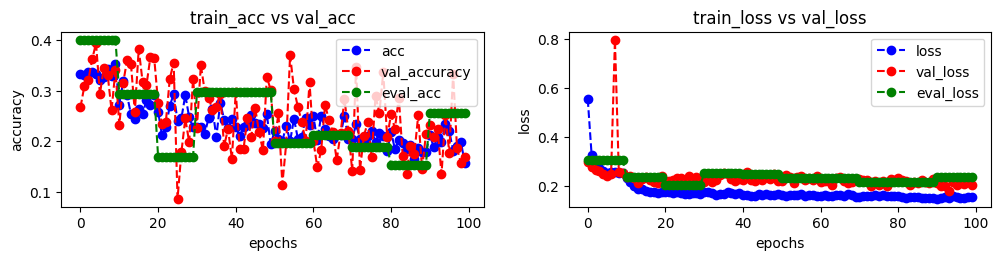

In [13]:
fig = plt.figure(figsize=(12,5))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo--', label = "acc")
plt.plot(history.history['val_accuracy'],'ro--', label = "val_accuracy")
plt.plot(accuracy_list,'go--', label = "eval_acc")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'],'bo--', label = "loss")
plt.plot(history.history['val_loss'],'ro--', label = "val_loss")
plt.plot(evaluation_list,'go--', label = "eval_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")

plt.legend()

In [ ]:
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=4)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=4)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    outputs = layers.Dense(3)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model